# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [32]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 177 kB/s  eta 0:00:01     |████████████▌                   | 18.3 MB 13.6 MB/s eta 0:00:03


#### Import libraries

In [29]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

import os
import io

from sklearn import preprocessing

!pip install pandas-profiling
from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize

# Libreria personalizada
import helpers

# Visualización de missing values
import missingno as msno

!pip install klib
import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import warnings
warnings.filterwarnings('ignore')

print("Successful import!!!")

Successful import!!!


In [5]:
# sagemaker libraries
import boto3
import sagemaker

##### Read dataset

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# The channels column is regulated by dividing each of the data
#portfolio = portfolio.explode('channels')
#portfolio.tail(5)

In [5]:
portfolio[portfolio['id'] == '2906b810c7d4411798c6938adc9daaa5']

,reward,channels,difficulty,duration,offer_type,id
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
profile[profile['id'] == '4869681400d94bfabe9d3923cc251b26']

,gender,age,id,became_member_on,income
12735,M,61,4869681400d94bfabe9d3923cc251b26,20151205,31000.0


In [6]:
# Display dataset profile
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### EDA (Exploratory Data Analysis)

In [8]:
print(f"Dataset portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns")
print(f"Dataset profile have {profile.shape[0]} rows and {profile.shape[1]} columns")
print(f"Dataset transcript have {transcript.shape[0]} rows and {transcript.shape[1]} columns")

Dataset portfolio have 10 rows and 6 columns
Dataset profile have 17000 rows and 5 columns
Dataset transcript have 306534 rows and 4 columns


Once the amount of data is taken into account, we will check how many missing values there are in each dataset.

##### Detect missing values for each dataset

<br>

##### Portfolio

In [9]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

As can be seen, this dataset does not have any null value.

##### Profile

In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
# Ratio of missing values to the actual dataset
print(f"There is a {round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)}% of missing values in the dataset Profile ")

There is a 12.79% of missing values in the dataset Profile 


##### Transcript

In [12]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Like the ``portfolio`` dataset, ``transcript`` has no missing values. 

<br> 

Let's explore each of the different events that can be seen within the transcript dataset.

In [13]:
transcript.groupby('event').count()

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


The following image shows the funnel of sales conversions of the marketing campaign. In the upper part are the ``offers received`` with a total of **76277**, in the middle part the ``offers viewed`` with **57725**, representing ``76%`` of the total ``offers received``.

<br>

Finally, the conversion of ``offers completed``  was **33579** which is ``44%`` of the offers sent.

<br> 

<img src="images/funnel.jpg"    
     style="max-width: 50%">

Now the event column of the ``transcript`` table will be normalized to know what type of event the ``offer_id`` refers to and thus interpret the data in depth. For this purpose, two functions were designed to meet this objective.


In [14]:
# Dataset del evento amount
transaction = helpers.merge_dataset(transcript, "value", "amount")
transaction.head(5)

,index,person,event,time,amount
0,12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
2,12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
4,12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [83]:
# Dataset del evento ofertas recibidas y vistas
offers = helpers.merge_dataset(transcript, "value", "offer id")
offers.head(5)

,index,person,event,time,offer id
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
# Event dataset of completed offers
offer_completed = helpers.merge_dataset(transcript, "value", "offer_id")
offer_completed.head(5)

,index,person,event,time,offer_id
0,12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5
1,12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4
2,12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd
4,12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [6]:
# Perform a merge to obtain a dataset of the completed columns along with the profile and portfolio table information.
final_dataset = pd.merge(profile, offer_completed, how="inner", left_on= "id",  right_on="person").\
            merge(portfolio, how="inner", left_on= "offer_id",  right_on="id")

columns_df_completed = ['id_x', 'index', 'id_y', 'offer_id', 'became_member_on', 'event', 'person']

# Delete columns
final_dataset.drop(columns_df_completed, axis=1, inplace=True)
final_dataset.head(5)

NameError: name 'profile' is not defined

In [7]:
final_dataset = pd.read_csv('unified_dataset.csv')
final_dataset.drop(['Unnamed: 0', 'user_id'], axis= 1, inplace=True)
final_dataset.head()

,age,gender,income,became_member_on,total_completed,total_viewed,total_received,total_spent,avg_spent,num_transactions,bogos_received,completed_bogo,discounts_received,completed_discount
0,55,F,112000.0,2017-07-15,1,0,2,77.01,25.670000,3,2,1,0,0
1,75,F,100000.0,2017-05-09,3,4,4,159.27,22.752857,7,9,3,0,0
2,68,M,70000.0,2018-04-26,2,3,4,57.73,19.243333,3,3,1,5,2
3,65,M,53000.0,2018-02-09,5,6,6,36.43,12.143333,3,11,2,6,2
4,58,M,51000.0,2017-11-11,1,2,3,15.62,3.905000,4,0,0,5,2


In [8]:
#Creating 'age_range' column based on 'age'
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
final_dataset['age_range'] = pd.cut(final_dataset['age'], bins = age_range_bins, labels = age_range_labels, right = False)
final_dataset.drop('age', axis= 1, inplace=True)

#Creating 'num_transactions_range' column based on 'num_transactions'
num_transactions_range_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30+']
num_transactions_range_bins = [0, 5, 10, 15, 20, 25, 30, 50]
final_dataset['num_transactions_range'] = pd.cut(final_dataset['num_transactions'], bins = num_transactions_range_bins, labels = num_transactions_range_labels, right = False)
final_dataset.drop('num_transactions', axis= 1, inplace=True)

#Creating 'bogos_received_range' column based on 'bogos_received'
bogos_received_range_labels = ['0-4', '5-9', '10-14', '15+']
bogos_received_range_bins = [0, 5, 10, 15, 25]
final_dataset['bogos_received_range'] = pd.cut(final_dataset['bogos_received'], bins = bogos_received_range_bins, labels = bogos_received_range_labels, right = False)
final_dataset.drop('bogos_received', axis= 1, inplace=True)

#Creating 'discounts_received_range' column based on 'discounts_received'
discounts_received_range_labels = ['0-4', '5-9', '10-14', '15+']
discounts_received_range_bins = [0, 5, 10, 15, 25]
final_dataset['discounts_received_range'] = pd.cut(final_dataset['discounts_received'], bins = discounts_received_range_bins, labels = discounts_received_range_labels, right = False)
final_dataset.drop('discounts_received', axis= 1, inplace=True)


final_dataset.drop('became_member_on', axis= 1, inplace=True)
#Adding a specific order to the age_range_field
#final_dataset['age_range'] = pd.Categorical(final_dataset['age_range'], ordered = True, categories = age_range_labels)


In [9]:
final_dataset.tail()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range
14820,F,54000.0,0,3,3,20.03,2.861429,1,1,40-49,5-9,0-4,0-4
14821,M,72000.0,1,1,3,25.97,3.710000,1,0,60-69,5-9,0-4,0-4
14822,M,73000.0,0,1,3,39.74,4.967500,0,1,40-49,5-9,0-4,0-4
14823,F,50000.0,3,3,3,189.67,13.547857,3,0,80+,10-14,5-9,0-4
14824,F,82000.0,2,2,4,143.02,23.836667,1,1,60-69,5-9,0-4,0-4


In [10]:
final_dataset.completed_discount.unique()

array([0, 2, 1, 3, 4])

In [11]:
# Check number rows and columns
final_dataset.shape

(14825, 13)

In [12]:
# Check missing values
final_dataset.isnull().sum()

gender                        0
income                        0
total_completed               0
total_viewed                  0
total_received                0
total_spent                   0
avg_spent                   333
completed_bogo                0
completed_discount            0
age_range                     0
num_transactions_range        0
bogos_received_range          0
discounts_received_range      0
dtype: int64

Now let's look at the missing values graphically. 

GridSpec(6, 6)

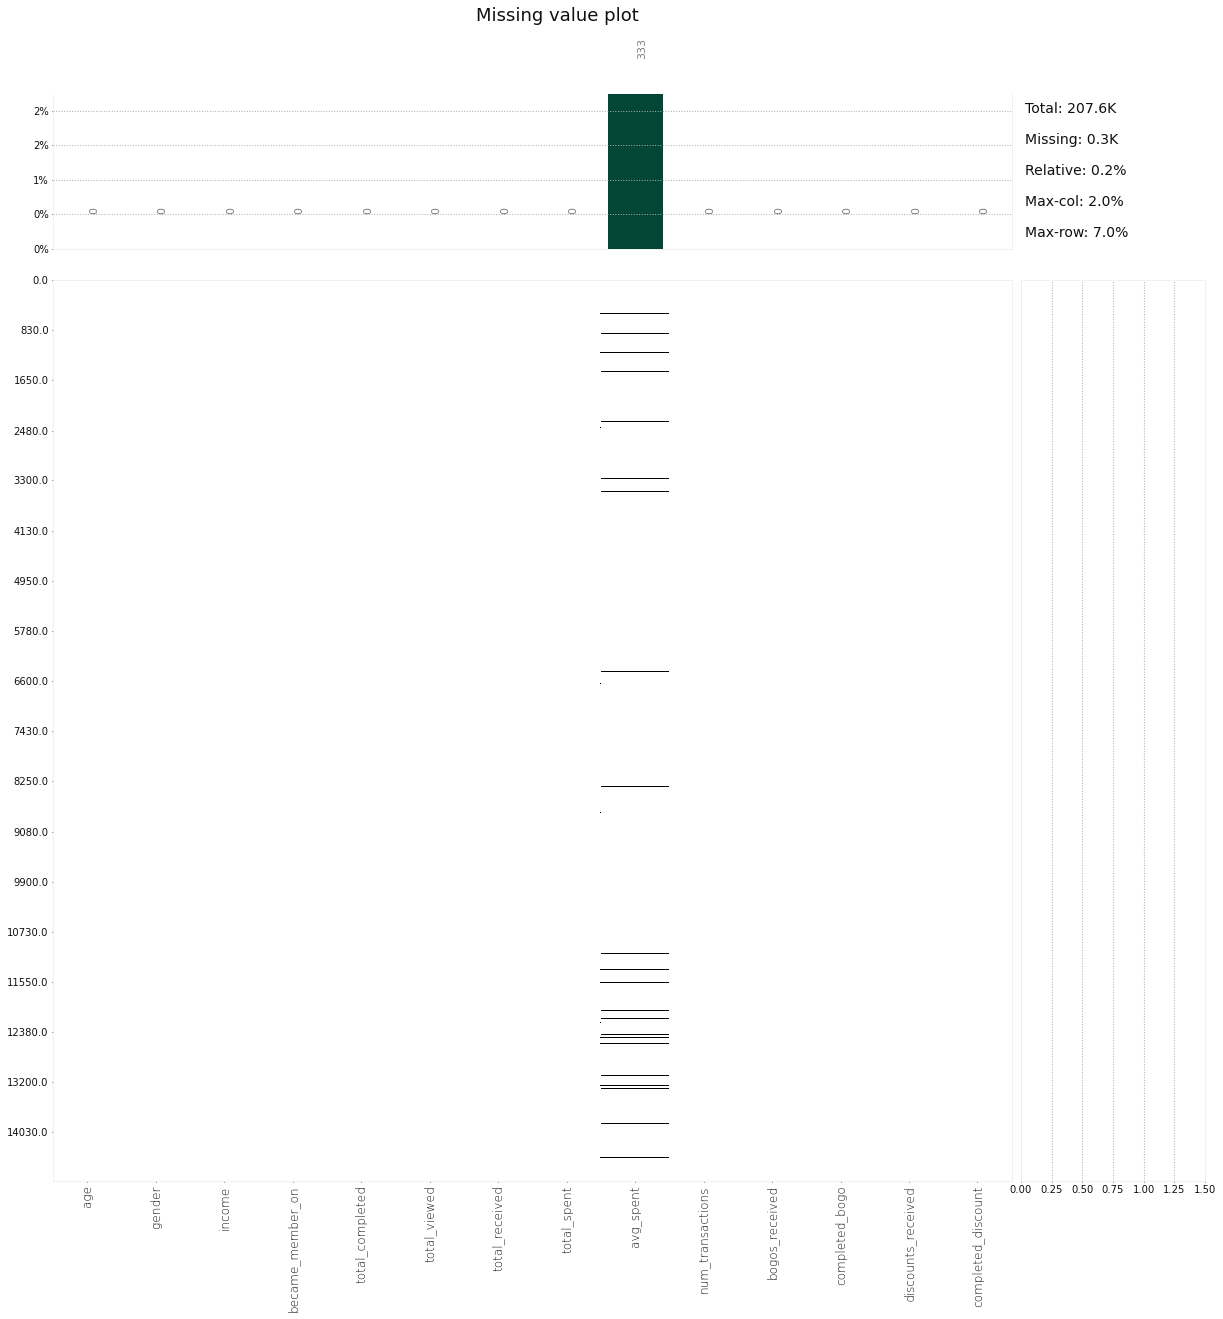

In [9]:
klib.missingval_plot(final_dataset)

A pattern can be observed in the missing values for the **gender** and **income** columns. The procedure to be performed is to remove each of these null values. 

In [13]:
# Delete missing values
final_dataset.dropna(inplace=True)

Since the number of unique individuals is less than 10,000, we will take as the final set simply the people who completed the offer, discriminating whether they completed one or more during the period that the marketing campaign was in force.

In [22]:
# Save dataset
#final_dataset.to_csv('final_dataset.csv')

In [23]:
#final_dataset = pd.read_csv('final_dataset.csv')
#final_dataset.drop('Unnamed: 0', axis= 1, inplace=True)
#final_dataset.shape

(32444, 9)

With the first data cleaning we performed in the previous steps, we will now generate a report to understand the nature of each of the data. 

In [88]:
# Portfolio report
report = ProfileReport(final_dataset, title='Report for final dataset V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report.to_file("final dataset.html")

In [89]:
report

In [14]:
# Change data type float to int 
for y in final_dataset.columns:
    if(final_dataset[y].dtype == np.float64):
        final_dataset[y] = final_dataset[y].astype(int)

final_dataset.dtypes

gender                        object
income                         int64
total_completed                int64
total_viewed                   int64
total_received                 int64
total_spent                    int64
avg_spent                      int64
completed_bogo                 int64
completed_discount             int64
age_range                   category
num_transactions_range      category
bogos_received_range        category
discounts_received_range    category
dtype: object

#### Statistics and Visualization

In [15]:
final_dataset.describe()

,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount
count,14492.000000,14492.000000,14492.000000,14492.000000,14492.000000,14492.000000,14492.000000,14492.000000
mean,65218.120342,2.238752,3.362131,4.486613,119.222261,14.753864,1.489235,1.490478
std,21599.246904,1.564696,1.284990,1.073723,130.216644,16.545880,0.865829,0.872196
min,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,1.000000,2.000000,4.000000,34.000000,3.000000,1.000000,1.000000
50%,63000.000000,2.000000,3.000000,5.000000,89.000000,14.000000,1.000000,1.000000
75%,79000.000000,3.000000,4.000000,5.000000,162.000000,21.000000,2.000000,2.000000
max,120000.000000,6.000000,6.000000,6.000000,1608.000000,451.000000,4.000000,4.000000


It can be observed that ``age`` presents an atypical value because its maximum value is **101** years. The following box-and-whisker plot shows this better. 

In [65]:
#sns.catplot(x='age', data=final_dataset, kind='box')
#plt.show()

In order to solve the above, we will work as a limit up to the ``third percentile``, that is, up to the age of **67** years. 

In [16]:
#final_dataset = final_dataset[final_dataset['age'] <= 67]
#print(f'Final number of customers: {final_dataset.shape[0]}')

Final number of customers: 10882


In [72]:
!pygmentize helpers.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn import preprocessing


def drop_missing_values(df, column, target_key):
    """
    
    drop_missing_values: Gets the specified event (target) and converts it into a dataframe.
    
    Parameters:
        df: Transcript dataset
        column: The name of the column where the json objects are located.
        target_key: Name of the key to extract the information
        
    Return:
        df: Normalized dataframe with the specified key, as column, and their respective values.
    """
    df = df[column].apply(pd.Series)
    
    df_final = df[[target_key]]
    df_final = df_final.dropna()
    df_final = df_final.reset_index()
    
    return df_final


def merge_dataset(general_dataset, column, target_key):
    """
    merge_dataset: merge transcript

After this filtering the final dataset is left with **24,579** data.

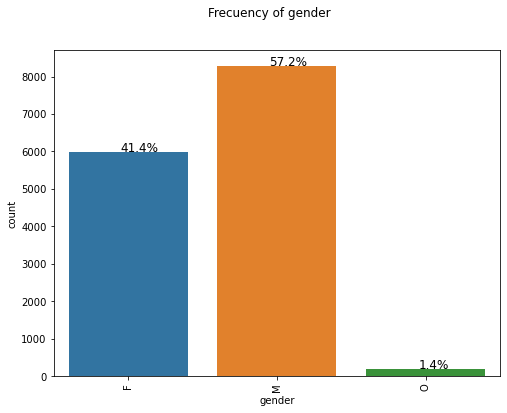

In [13]:
# Display plot for gender column
helpers.plot_category_variable(final_dataset, 'gender')

As can be seen, the majority of the population is **male** with ``57.2%`` followed by **females** with ``41.4%`` and finally **Others** with only ``1.4%`` of our data set.

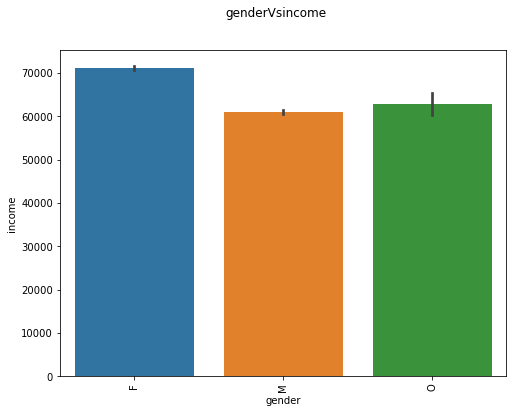

In [12]:
# Display plot Gender VS Income
helpers.plot_cat_num_variable(final_dataset, "gender", "income")

The above shows us a very important detail, which is that despite the fact that **women** represent **41%** of the total population, this gender had a higher income than **men** and **Others**.

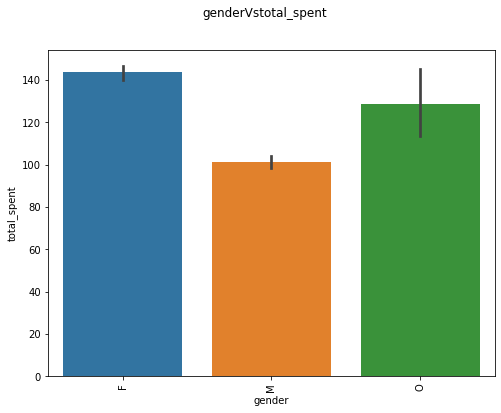

In [16]:
# Display plot Gender VS Total spent
helpers.plot_cat_num_variable(final_dataset, "gender", "total_spent")

Based on the above, **women** are those who spend more on the offers than **men** and **Others**.

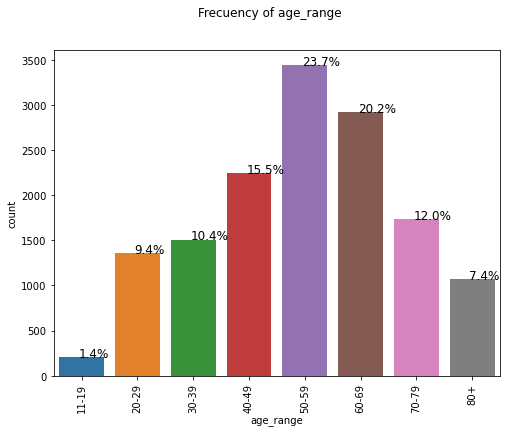

In [67]:
# Display plot for age_range column
helpers.plot_category_variable(final_dataset, 'age_range')

According to the graph, it can be concluded that ``60%`` of the population is in the age range **40 - 69 years old**, belonging to the ``Baby boomers`` generation. On the other hand, ``Millenials`` represent only **20%** of the population.

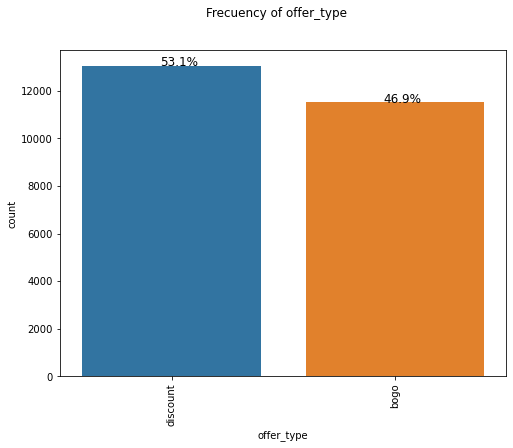

In [29]:
# Display plot for offer_type column
helpers.plot_category_variable(final_dataset, 'offer_type')

**Discount** is the type of offer with the highest share in the data set with ``53.1%`` compared to the **BOGO** offer with ``46.9%``.

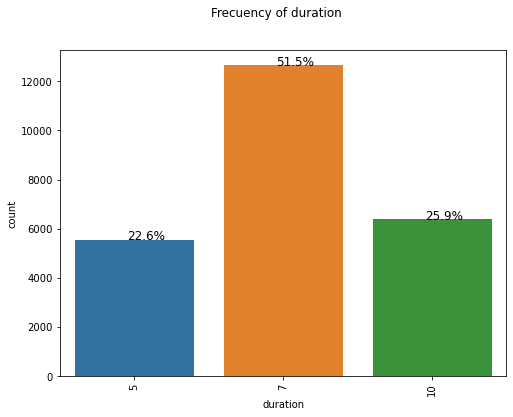

In [30]:
# Display plot for duration column
helpers.plot_category_variable(final_dataset, 'duration')

For this marketing campaign used by Starbucks, they decided to give priority to offers with a duration of **7 days** with ``51.5%``, followed by **10 days** with ``25.9%`` and finally **5 days** with a total percentage of ``22.6%``.

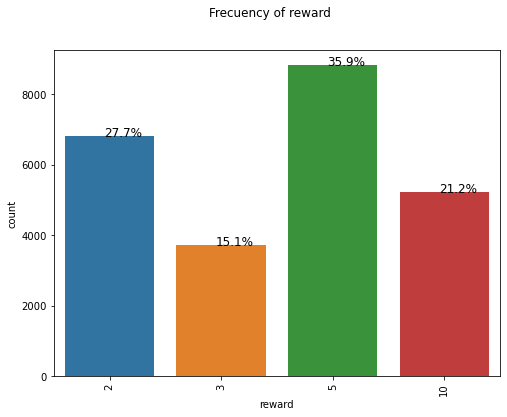

In [31]:
# Display plot for reward column
helpers.plot_category_variable(final_dataset, 'reward')

As can be seen in the graph, the distribution of ``rewards`` is not linear since the highest percentage is **5 USD** with ``35.9%`` of the total data, followed by **2 USD** representing ``27.7%``, **10 USD** with ``21.2%`` and finally **3 USD** with a proportion of ``15.1%`` of the 24579 completed offers.

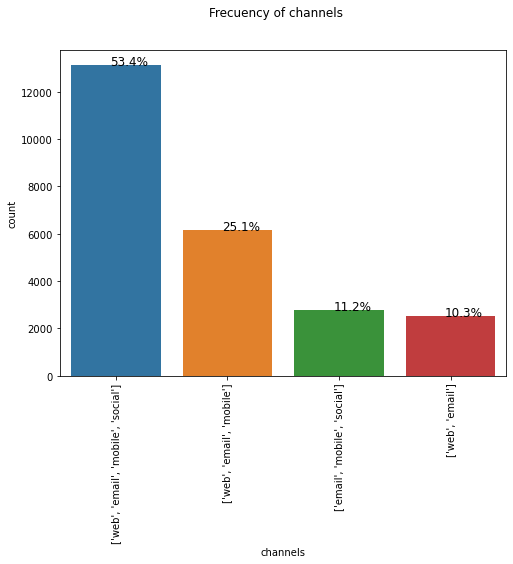

In [32]:
# Display plot for reward column
helpers.plot_category_variable(final_dataset, 'channels')

When analyzing the distribution of the **channels** through which the offers were generated, it can be concluded that customers receive them in different sets of channels, the most used being **['web', 'email', 'mobile', 'social']**, representing ``53.4%`` of the total data set. In turn, offers sent only by **['web', 'email', 'mobile']** accounted for ``25.1%``. Meanwhile, the set of channels with the lowest proportion was **['web', 'email']** with ``10.3%``.

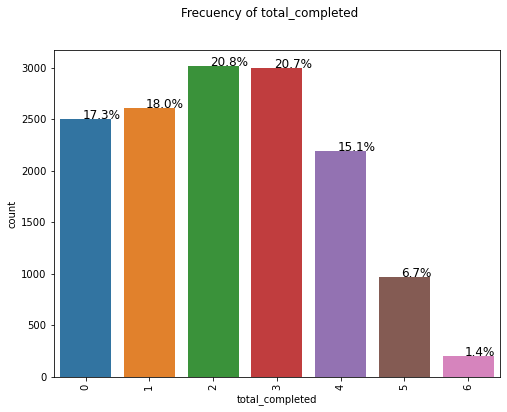

In [38]:
# Display plot for total_completed column
helpers.plot_category_variable(final_dataset, 'total_completed')

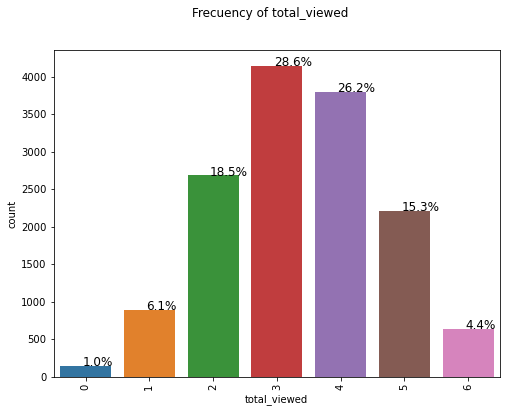

In [39]:
# Display plot for total_viewed column
helpers.plot_category_variable(final_dataset, 'total_viewed')

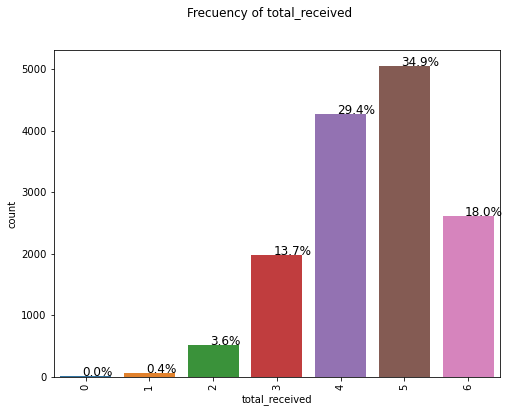

In [40]:
# Display plot for total_received column
helpers.plot_category_variable(final_dataset, 'total_received')

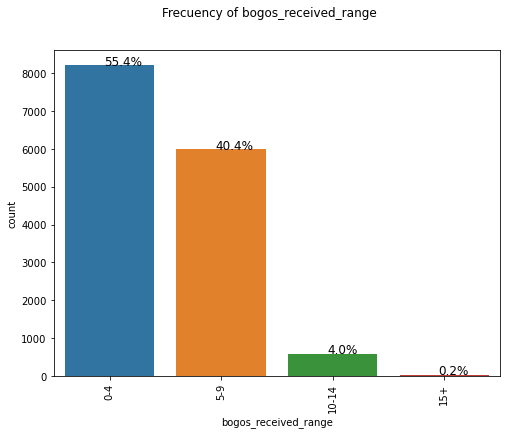

In [43]:
# Display plot for bogos_received column
helpers.plot_category_variable(final_dataset, 'bogos_received_range')

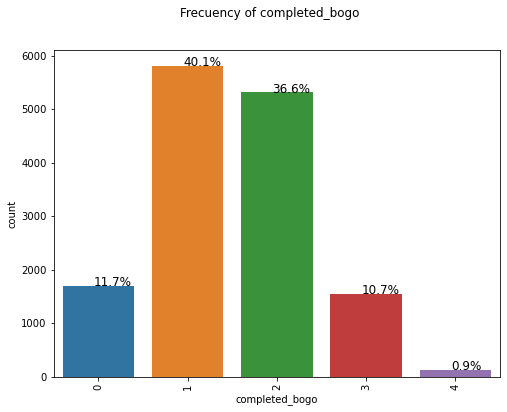

In [44]:
# Display plot for completed_bogo column
helpers.plot_category_variable(final_dataset, 'completed_bogo')

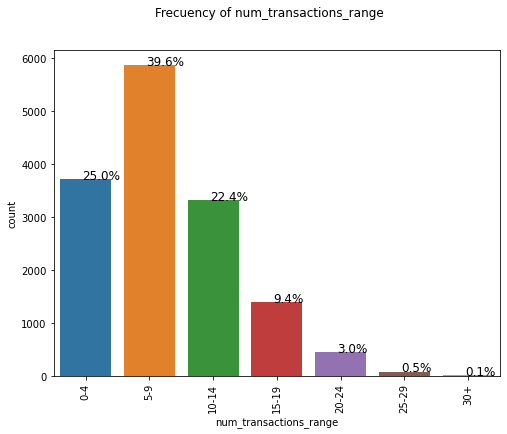

In [44]:
# Display plot for num_transactions_range column
helpers.plot_category_variable(final_dataset, 'num_transactions_range')

In [45]:
final_dataset.columns

Index(['gender', 'income', 'became_member_on', 'total_completed', 'total_viewed', 'total_received', 'total_spent', 'avg_spent', 'completed_bogo', 'completed_discount', 'age_range', 'num_transactions_range', 'bogos_received_range', 'discounts_received_range'], dtype='object')

In [48]:
final_dataset.dtypes

gender                        object
income                       float64
became_member_on              object
total_completed                int64
total_viewed                   int64
total_received                 int64
total_spent                  float64
avg_spent                    float64
completed_bogo                 int64
completed_discount             int64
age_range                   category
num_transactions_range      category
bogos_received_range        category
discounts_received_range    category
dtype: object

In [50]:
# Select columns with numeric data types
numeric_columns = final_dataset.select_dtypes([np.int32, np.int64])
numeric_columns = final_dataset[['income', 'avg_spent','total_spent']]

<Figure size 432x288 with 0 Axes>

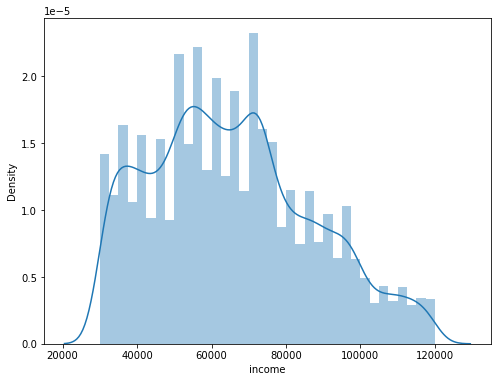

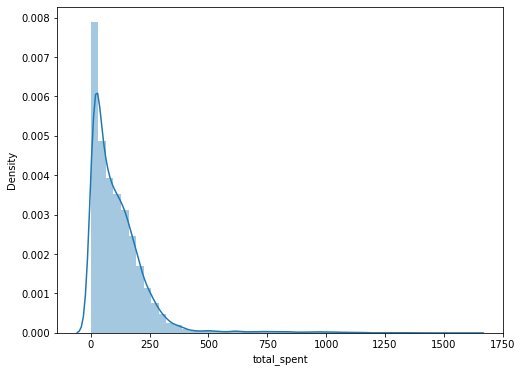

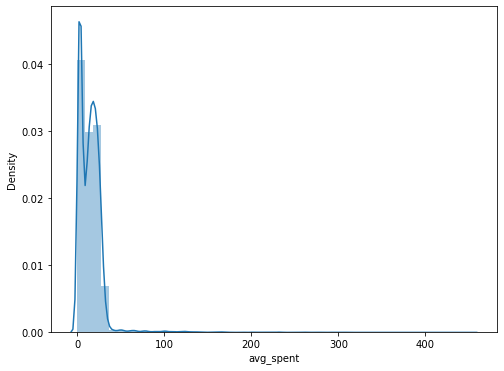

In [51]:
for i, col in enumerate(numeric_columns.columns):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    
    sns.distplot(numeric_columns[col])
    plt.figure(i)

We will now detail the type of asymmetry of each of the graphs shown above.

In [54]:
# Choose numeric datatype
numeric_features = final_dataset.select_dtypes(include=[np.number]).columns
skew_features = final_dataset[numeric_features].skew().sort_values(ascending = False)

# Print skew features
skew_features

avg_spent             7.373793
total_spent           3.575535
income                0.402005
total_completed       0.222212
completed_bogo        0.180983
completed_discount    0.166181
total_viewed         -0.061916
total_received       -0.459248
dtype: float64

It can be observed that the different types of *skewness* among the numerics. Meanwhile, based on our previous graphs, the **avg_spent**, **total_spent** and **income** columns have a ``positively skewed`` distribution with an skewness of greater than **0**.



##### Hopkins Statistics
Tests the spatial randomness of the data and indicates the clustering tendency or how well the data may be clustered
* **0.5 or less** --> data are uniformly distributed
* **0.77 - 0.99** --> high clustering tendency

In [59]:
helpers.hopkins(final_dataset[numeric_features])

0.9887539623409382

As can be seen the Hopkins statistic shows that the data set has a high tendency to be clustered, which is a good sign to be able to apply the clustering algorithms that will be discussed later.

#### Preprocessing data

<br>

Next, a comparison will be made with different rescalers that will allow a decision to be made for the best case with respect to the data set that is being worked on. Three rescalers will be analyzed: ``Robust Scaler``, ``Standard Scaler`` and ``Min Max Scaler``.

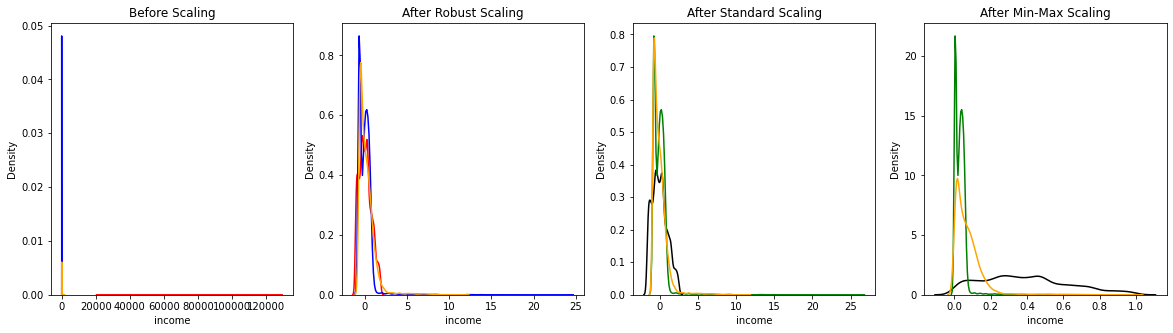

In [16]:
# Select colummns
columns = ['income', 'avg_spent','total_spent']

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(final_dataset[['income', 'avg_spent','total_spent']])
robust_df = pd.DataFrame(robust_df, columns = columns)
  
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(final_dataset[['income', 'avg_spent','total_spent']])
standard_df = pd.DataFrame(standard_df, columns = columns)
  
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(robust_df[['income', 'avg_spent','total_spent']])
minmax_df = pd.DataFrame(minmax_df, columns = columns)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
  
sns.kdeplot(final_dataset['income'], ax = ax1, color ='r')
sns.kdeplot(final_dataset['avg_spent'], ax = ax1, color ='b')
sns.kdeplot(final_dataset['total_spent'], ax = ax1, color ='orange')
ax2.set_title('After Robust Scaling')
  
sns.kdeplot(robust_df['income'], ax = ax2, color ='red')
sns.kdeplot(robust_df['avg_spent'], ax = ax2, color ='blue')
sns.kdeplot(robust_df['total_spent'], ax = ax2, color ='orange')
ax3.set_title('After Standard Scaling')
  
sns.kdeplot(standard_df['income'], ax = ax3, color ='black')
sns.kdeplot(standard_df['avg_spent'], ax = ax3, color ='g')
sns.kdeplot(standard_df['total_spent'], ax = ax3, color ='orange')
ax4.set_title('After Min-Max Scaling')
  
sns.kdeplot(minmax_df['income'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['avg_spent'], ax = ax4, color ='g')
sns.kdeplot(minmax_df['total_spent'], ax = ax4, color ='orange')
plt.show()

First to do the pre-processing we applied [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) because it removes outliers from the data. However, for the columns we are interested in, not all of them are organized in the same range because  ``time`` is in the range of *-1 to 1*, but ``income`` is in -2 and 2. What we want is that all the specified columns are in the same range, therefore, applying [**MinMaxScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) will achieve this since all the columns are in the range of *0 to 1*. 

In conclusion, first **RobustScaler** and then **MinMaxScaler** will be applied. Finally, coding of the categorical variables will be applied using **LabelEncoder**. And for this, a function that is in the file ``helpers.py`` will be performed. 

In [17]:
data_transform = helpers.preprocessing_data(final_dataset)
data_transform.head()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range
0,0,0.911111,1,0,2,0.047886,0.055432,1,0,4,0,0,0
1,0,0.777778,3,4,4,0.098881,0.048780,3,0,6,6,3,0
2,1,0.444444,2,3,4,0.035448,0.042129,1,2,5,0,0,3
3,1,0.255556,5,6,6,0.022388,0.026608,2,2,5,0,1,3
4,1,0.233333,1,2,3,0.009328,0.006652,0,2,4,0,0,3


In [21]:
data_transform.shape

(14492, 13)

The following is a detailed description of the meaning of each of the labels that ``Label Encoder`` has created with the categorical variables:

<br>

##### Gender
* **F:** 0
* **M:** 1
* **O:** 2

<br>

##### reward
* **2:** 0
* **3:** 1
* **5:** 2
* **10:** 3

<br>

##### channels
* **['email', 'mobile', 'social']:** 0
* **['web', 'email', 'mobile', 'social']:** 1
* **['web', 'email', 'mobile']:** 2
* **['web', 'email']:**  3
 
 <br>

##### difficulty
* **5:** 0
* **7:** 1
* **10:** 2
* **20:** 3

<br>

##### duration
* **5:** 0
* **7:** 1
* **10:** 2

<br>

##### offer type
* **bogo:** 0
* **discount:** 1


### Dimensionality Reduction
###### Roles and Buckets

In [18]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::523506571102:role/service-role/AmazonSageMaker-ExecutionRole-20210613T222655


In [19]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-523506571102



##### Define a PCA Model


* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.


In [20]:
# define location to store model artifacts
prefix = 'starbucks'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-523506571102/starbucks/


In [25]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS = data_transform.shape[1] - 1

pca_starbucks = PCA(role=role,
             instance_count=1,
             instance_type='ml.p2.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

#### Convert data into a RecordSet format

In [26]:
# convert df to np array
train_data_np = data_transform.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_starbucks.record_set(train_data_np)

##### Train the model

In [27]:
%%time

# train the PCA mode on the formatted data
pca_starbucks.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-15 04:16:29 Starting - Starting the training job...
2021-06-15 04:16:55 Starting - Launching requested ML instancesProfilerReport-1623730589: InProgress
......
2021-06-15 04:17:55 Starting - Preparing the instances for training.........
2021-06-15 04:19:26 Downloading - Downloading input data...
2021-06-15 04:19:55 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/15/2021 04:20:17 INFO 140191019775808] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[06/15/2021 04:20:17 INFO 140191019775808] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '13', 'num_components'

##### Accessing the PCA Model Attributes

In [30]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-06-15-04-16-29-767'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

starbucks/pca-2021-06-15-04-16-29-767/output/model.tar.gz


2304

##### MXNet Array

In [33]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[  8.438107  26.052725  58.92699   61.85653   77.91846   96.84747
 115.36534  138.65338  206.45712  207.58713  255.2141   313.41544 ]
<NDArray 12 @cpu(0)>, 'v': 
[[-3.38962884e-03  7.77352378e-02 -6.40263855e-01  7.58074582e-01
   4.89646394e-04 -7.00206775e-03  4.61183563e-02  6.57672584e-02
  -2.21301205e-02  3.49327587e-02  3.34061719e-02 -5.68130112e-04]
 [ 8.81938189e-02  9.90357220e-01  2.75668427e-02 -6.97451606e-02
  -9.18787345e-03  1.31739201e-02 -2.52847243e-02 -3.58306542e-02
   2.24511921e-02 -3.18751037e-02 -2.59705670e-02  5.11000259e-03]
 [ 2.64852419e-02 -4.50394414e-02 -8.50060359e-02  3.84554341e-02
   2.22797710e-02 -3.81313190e-02 -5.31287849e-01 -5.56426227e-01
  -6.58445060e-02  5.21495286e-03 -6.22144520e-01  5.73521331e-02]
 [ 3.99537152e-03  3.60715040e-03  1.30998075e-01  8.67859721e-02
  -1.49624914e-01  5.86561620e-01 -1.90663114e-01  6.05458677e-01
  -1.18217422e-02  1.45072430e-01 -4.29768533e-01  4.13721800e-03]
 [-4.10519214e-03  9.96722281e-03 -

#### PCA Model Attributes

In [34]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

##### Data Variance

In [40]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  

# print a selection of s
print(s.iloc[start_idx:, :])

             0
7   138.653381
8   206.457123
9   207.587128
10  255.214096
11  313.415436


In [41]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [47]:
# test cell
n_top_components = 5 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.87936157
